In [5]:
!python --version
# !pip3 install numpy
# !pip3 install sympy
# !pip3 install scipy
# !pip3 install matplotlib
# !pip3 install tqdm
# !pip3 install quimb

Python 3.10.0


In [12]:
import numpy as np
import sympy as sym
import scipy.linalg as scilin
import scipy as scipy
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
from tqdm import tqdm

import quimb as qu
import quimb.tensor as qtn

import jax; import optax; import jax.numpy as jnp
from jaxopt import OptaxSolver

SystemError: initialization of _internal failed without raising an exception

 9 9 9 9 
●─●─●─●─●
│ │ │ │ │


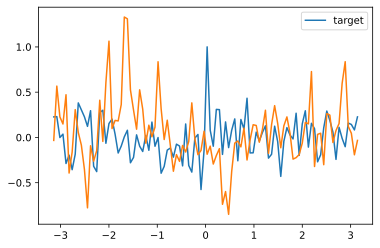

In [47]:
def real_target_function(degree, x):
    real = np.random.rand(2*degree)
    coeffs = real 
    res = 0
    for d in range(degree):
        res += coeffs[d]*np.cos((d+1)*x) + np.conj(coeffs[d])*np.sin((d+1)*x)
        
    return np.real(res)/np.max(np.real(res))

def target_function(degree, x):
    real = np.random.rand(degree); imag = np.random.rand(degree)
    coeffs = real + 1j*imag
    res = 0
    for d in range(degree):
        res += coeffs[d]*np.exp(-1j*(d+1)*x) + np.conj(coeffs[d])*np.exp(1j*(d+1)*x)
    return np.real(res)/np.max(np.real(res))

degree = 3**5

x = np.linspace(-np.pi,np.pi,100)
target = target_function(degree,x)

n = 5
basis_s = tri_basis_tensor(n, x , 'exp')
bond_dim = 9 #int(3**np.floor(degree/2))
coeff = coeff_tensor(n, bond_dim)
coeff.show()

plt.plot(x, target, label = 'target')
plt.plot(x, predict(coeff,basis_s))
plt.legend()

In [48]:
n_qubits = 5
n_layers = 5

dev = qml.device('default.qubit', wires = n_qubits)

@jax.jit
@qml.qnode(dev, interface = 'jax')
def quantum_model(x, weights ):
    def S(x):
        for i in range(n_qubits):
            qml.RZ((3**i)*x, wires = i)
    # W takes (n_layer, n_qubits, 3) shape array        
    def W(weights, n_layers):
        for L in range(n_layers):
            
            for i in range(n_qubits):
                qml.Rot(weights[L,i,0], weights[L,i,1], weights[L,i,2], wires = i)
            for i in range(n_qubits-1):
                qml.CNOT(wires = [i,i+1])
            
    
    W(weights[0], n_layers)
    S(x)
    W(weights[1], n_layers)
    
    return qml.expval(qml.PauliZ(wires = [n_qubits-1]))



@jax.jit
def cost(weights, x, y):
    predictions = quantum_model(x,weights)
    loss = 0.5*jnp.mean(jnp.square(predictions - y))
    return loss


max_steps = 300
learning_rate = 0.01
batch_size = len(x)

key = jax.random.PRNGKey(np.random.randint(20000))

weights =  2 * jnp.pi *jax.random.normal(key, (2,n_layers,  n_qubits, 3) )

opt1 = optax.adam(learning_rate)
opt1_state = opt1.init(weights)

train_cst = []


for step in range(max_steps):
    key = jax.random.PRNGKey(step)

    x_batch = jnp.array(x)
    y_batch = jnp.array(target)

    ### Update the weights by one optimizer step
    grads1 = jax.grad(cost, argnums = 0)( weights,  x_batch, y_batch)

    updates1, opt1_state = opt1.update(grads1, opt1_state)

    weights = optax.apply_updates(weights, updates1)

    ## train cost
    train_c1 = cost(weights, x_batch,y_batch)
    train_cst.append(train_c1)

    #if cst[-1]<=min(cst):
    #    with open(f'steplike/min_step_weights_{n_qubits}_3.npy', 'wb') as f:
    #        np.save(f,weights)
    if (step + 1) % 20 == 0:
        print("Train cost of naive at step {0:3}: {1}".format(step + 1, train_c1))





Train cost of naive at step  20: 0.013112728483974934
Train cost of naive at step  40: 0.007217444479465485
Train cost of naive at step  60: 0.005300293676555157
Train cost of naive at step  80: 0.004378119949251413
Train cost of naive at step 100: 0.0037923993077129126
Train cost of naive at step 120: 0.0033339373767375946
Train cost of naive at step 140: 0.0029489423613995314
Train cost of naive at step 160: 0.0026324810460209846
Train cost of naive at step 180: 0.002318673301488161
Train cost of naive at step 200: 0.0020126064773648977
Train cost of naive at step 220: 0.0018138502491638064
Train cost of naive at step 240: 0.0016824961639940739
Train cost of naive at step 260: 0.0015861456049606204
Train cost of naive at step 280: 0.0015095495618879795
Train cost of naive at step 300: 0.0014406226109713316


In [49]:

coeff_auto = coeff.copy()


In [50]:
##Compare between adam and dmrg like
##It only works for real basis and real coeffs

def callback(tnopt):
    loss_list.append(tnopt.loss)
    return loss_list

loss_list = []
opt = qtn.optimize.TNOptimizer(coeff_auto, loss, loss_constants = {'basis_s' : basis_s, 'target' : target}, optimizer = 'adam',autodiff_backend = 'jax',progbar = True, callback = callback)
after_coeff_auto = opt.optimize(300, jac = True)

test = MPSOptimizer(coeff, x, target, tri_basis_tensor)
after_coeff_dmrg = test.update2(300, learning_rate = -0.1,max_bond = n)




+0.000729538035 [best: +0.000729538035] : : 301it [00:26, 11.52it/s]                        
  0%|          | 0/300 [00:00<?, ?it/s]


TypeError: Argument '<__main__.MPSOptimizer object at 0x7f773e7df820>' of type <class '__main__.MPSOptimizer'> is not a valid JAX type.

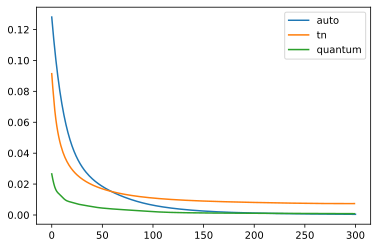

In [44]:
plt.plot(loss_list[:], label = 'auto')
plt.plot(test.loss_list[:], label = 'tn')
plt.plot(train_cst[:], label = 'quantum')

plt.legend()

## Check the singular values of all cuts of quantum circuit generated coefficient tensor

In [8]:
## quantum circuit = W 를 quimb 를 이용해 만들고, 그 circuit에 의해 evolution된 observable = W^{\dag}Z^(N)W의 singular value들을 확인할겁니다.
##

## 일단 0 state들을 전부 H 가해줘서 모든 computational basis들의 superposition을 만들고, Z rotation으로 인코딩 하는 경우.
## 근데 이 encoding은 W^{\dag}Z^(N)W 와 관계 없습니다.
def encoding_layer(circ, inputs, gate_round = None):
    
    for i in range(circ.N):
        circ.apply_gate('H', i, gate_round =0)
    for i in range(circ.N):
        circ.apply_gate('RZ', inputs, i, gate_round =1)
    
    
## single qubit layer를 각 큐빗마다 가합니다.    
def single_qubit_layer(circ, params, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        circ.apply_gate(
            'U3', *params[gate_round,i], i, 
            gate_round=gate_round, parametrize=True)
        
## CNOT layer를 가합니다.        
def two_qubit_layer(circ, gate2='CNOT', reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)
    
    for i in regs:
        circ.apply_gate(
            gate2, i, i + 1, gate_round=gate_round)
        
## encoding을 포함하는 서킷
def ansatz_circuit(n, depth, params, inputs,gate2='CNOT', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)
    
    encoding_layer(circ, inputs)
  
    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, params, gate_round=r)
        
        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r) #reverse=r % 2 == 0)
        
    # add a final single qubit layer
    # single_qubit_layer(circ, gate_round=r + 1)
     
    return circ

## encoding 없는 circuit. 우리가 할 W^{\dag}Z^(N)W 에 사용될 놈입니다.
def noinput_ansatz_circuit(n, depth,params,gate2='CNOT', **kwargs):
    circ = qtn.Circuit(n, **kwargs)
  
    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, params, gate_round=r)
        
        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r)# reverse=r % 2 == 0)
 
    return circ


## 주어진 통짜 tensor T 가 주어지면 MPO 형태로 바꾸는 함수입니다. 왼쪽 인덱스는 i1, i2, ... 으로 통일하고 오른쪽 인덱스는 j1, j2, ... 으로 통일 했습니다.

def MPO_from_dense(T, n,inds = ('i','j'), **kwargs ):
    tlist =[[] for _ in range(n)]
    
    ## qtn.tensor_split은 SVD 하는 함수입니다. 중요!
    L, R = qtn.tensor_split(T, left_inds = (f'{inds[0]}0', f'{inds[1]}0'), bond_ind = f'bond0', max_bond = kwargs['max_bond'], absorb = kwargs['absorb'] , cutoff_mode =kwargs['cutoff_mode'] , cutoff = kwargs['cutoff'])
    
    tlist[0] = L
    tlist[0].drop_tags()
    tlist[0].add_tag('M0')
    
    T = R
    for it in range(1,n-1):
        L, R = qtn.tensor_split(T, left_inds = (f'{inds[0]}{it}',f'bond{it-1}', f'{inds[1]}{it}'), bond_ind = f'bond{it}' , max_bond = kwargs['max_bond'], absorb = kwargs['absorb'], cutoff_mode = kwargs['cutoff_mode'] ,cutoff = kwargs['cutoff'])
        tlist[it] = L
        tlist[it].drop_tags()
        tlist[it].add_tag(f'M{it}')
        
        T = R
    tlist[n-1] = T
    tlist[n-1].drop_tags()
    tlist[n-1].add_tag(f'M{n-1}')
    
    return qtn.TensorNetwork(tlist)

In [9]:
# MPO를 저희가 원하는 MPS 모양으로 바꿔주는 projection 얘들입니다. 그림에서 제가 leg들 접었던걸 해주고, exponential basis function들을 trigonometric function form으로 바꿔주는 역할을 합니다.

def R_net(length):
    Rs = [ qtn.Tensor(np.array([ [[0,1,0],[0,0,1]],[[1,0,0],[0,1,0]]  ]), inds = [f'i{it}',f'j{it}',f'k{it}'], tags ={f'T{it}'}) for it in range(length)]
    return qtn.TensorNetwork(Rs)

def Q_net(length):
    Qs = [ qtn.Tensor([[0,1,-1j],[1,0,0],[0,1,1j]], inds =(f'k{it}', f'b{it}'), tags = {f'R{it}'}) for it in range(length)]
    return qtn.TensorNetwork(Qs)


def tri_basis_change(mpo,n):

    rnet = R_net(n)
    qnet = Q_net(n)
    res = (mpo & rnet & qnet)
    for it in range(n):
        res = res.contract(tags = {f'T{it}', f'M{it}', f'R{it}'})
    return res

In [38]:
n = 4
depth = 10
max_edge_ind = int(np.floor(n/2))
params = qu.rand((depth,n,3),dist = 'normal')

## This is for Qmpo making. SVD할 때 필요한 여러 키워드들
split_kwargs = {'absorb' : 'right', 'max_bond' : None ,'cutoff_mode' : 'sum2', 'cutoff' : None}

## circ 는 이제 W 을 구현한 quantum circuit.
gate2 = 'CNOT'
circ = noinput_ansatz_circuit(n, depth, params, gate2=gate2)

## local Z 는 마지막 qubit에만 Z가 가해지고 나머지는 I가 tensor product된 형태입니다. 그래서 I n-1개와 Z 1개로 이루어진 리스트를 만들고, 이 리스트로부터 텐서 네트워크를 만드는 방식으로 local Z를 만들어줍니다.
ts = [ qtn.Tensor(qu.eye(2), inds = (f'bin{k}', f'bout{k}')) for k in range(n-1)] + [qtn.Tensor(qu.pauli('z'), inds = (f'bin{n-1}', f'bout{n-1}'))]
M = qtn.TensorNetwork(ts)

## circ 자체를 그냥 매트릭스로 표현
W = circ.uni;
Wd = W.copy()
W = W.reindex({f'b{k}' : f'bout{k}' for k in range(n)}).reindex({f'k{k}':f'j{k}' for k in range(n)})
Wd = Wd.H.reindex({f'b{k}' : f'bin{k}' for k in range(n)}).reindex({f'k{k}':f'i{k}' for k in range(n)})

# big block of given qunatum circuitted observable with normalization
con = (0.5**n)*(Wd & M & W).contract()

# W^{\dag}ZW 를 MPO로 바꿈
Qmpo = MPO_from_dense(con, n, **split_kwargs)

# leg 접고 projection해서 MPS로 바꿈. 이제 physical dimension이 3 인 MPS가 만들어졌습니다.
Tmps = tri_basis_change(Qmpo,n)

# 'real' bond dimension을 찾기 위해서 quimb.tensor 에 내장되어 있는 compress function을 씀.
Tmps = qtn.MatrixProductState(Tmps.arrays,  site_ind_id = 'b{}') 
Tmps.compress('left',max_bond = None, cutoff_mode = 'sum2', cutoff =0.0)

# 이제 MPS는 n개의 site가 있으니 n-1개의 bond line이 있고, 얘네들의 schmidt_values (= singular values) 를 뽑아냅니다.
#Tmpssv[k] 에 k번째 컷의 singular value들이 저장됩니다.
Tmpssv = np.empty((n,int(3**max_edge_ind)))
for k in range(n-1):
    smtv = Tmps.schmidt_values(k+1)
    Tmpssv[k] = np.pad(smtv, (0,int(3**max_edge_ind) - len(smtv)), 'constant',constant_values = 0)

quantum circuit result :  -0.020657327561915566


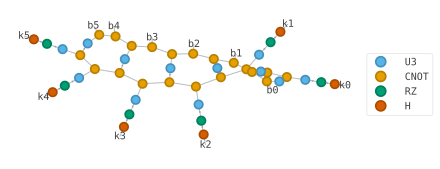

In [ ]:
n = 6
depth = 2
inputs = 4.2
gate2 = 'CNOT'

## randomly initialize trainable parameters
params = qu.rand((depth,n,3),dist = 'uniform')

circ = ansatz_circuit(n, depth, params, inputs, gate2=gate2)
res1 = circ.local_expectation(qu.pauli('Z'), (n-1))
print('quantum circuit result : ',res1.real)
W = circ.uni

## k to the b index

W.draw(color = ['U3', gate2, 'RZ', 'H'], show_inds = True)

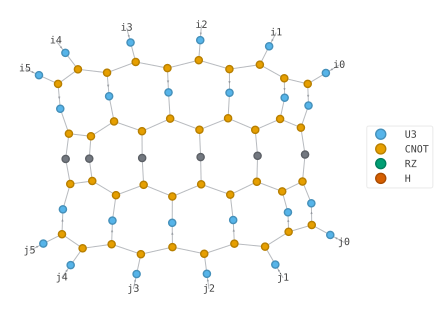

In [ ]:
## From here we generate equivalent (exact) TN
circ = noinput_ansatz_circuit(n, depth, params, gate2=gate2)
W = circ.uni
Wd = W.copy()

## generating observable
ts = [ qtn.Tensor(qu.eye(2), inds = (f'bin{k}', f'bout{k}')) for k in range(n-1)] + [qtn.Tensor(qu.pauli('z'), inds = (f'bin{n-1}', f'bout{n-1}'))]
M = qtn.TensorNetwork(ts)

W = W.reindex({f'b{k}' : f'bout{k}' for k in range(n)}).reindex({f'k{k}':f'j{k}' for k in range(n)})
Wd = Wd.H.reindex({f'b{k}' : f'bin{k}' for k in range(n)}).reindex({f'k{k}':f'i{k}' for k in range(n)})

WdMW = Wd& M& W 
con = WdMW.contract()
## con is surely hermitian. #con.data.reshape((2**n,2**n)).round(12) == con.data.reshape((2**n,2**n)).T.conj().round(12) all True

WdMW.draw(color = ['U3', gate2, 'RZ', 'H'], show_inds = True, show_tags =False)


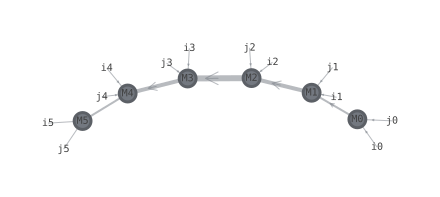

max bond of Qmpo = 64 
max bond of compressed Qmpo = 4


{0: Tensor(shape=(2, 2, 4), inds=('i0', 'j0', 'bond0'), tags=oset(['M0'])),
 1: Tensor(shape=(2, 4, 2, 16), inds=('i1', 'bond0', 'j1', 'bond1'), tags=oset(['M1'])),
 2: Tensor(shape=(2, 16, 2, 64), inds=('i2', 'bond1', 'j2', 'bond2'), tags=oset(['M2'])),
 3: Tensor(shape=(2, 64, 2, 16), inds=('i3', 'bond2', 'j3', 'bond3'), tags=oset(['M3'])),
 4: Tensor(shape=(2, 16, 2, 4), inds=('i4', 'bond3', 'j4', 'bond4'), tags=oset(['M4'])),
 5: Tensor(shape=(4, 2, 2), inds=('bond4', 'i5', 'j5'), tags=oset(['M5']))}

In [ ]:
## generating mpo version 
split_kwargs = {'absorb' : 'right', 'max_bond' : None ,'cutoff_mode' : 'sum2', 'cutoff' : None}

Qmpo = MPO_from_dense(con,  **split_kwargs)
Qmpo_comp = MPO_from_dense(con, absorb = 'right', max_bond = n,cutoff = 1e-6, cutoff_mode = 'sum2')
Qmpo.draw(show_tags = True)

print(f'max bond of Qmpo = {Qmpo.max_bond()} \nmax bond of compressed Qmpo = {Qmpo_comp.max_bond()}')
Qmpo.tensor_map

In [ ]:
## generating basis changed version
def T_net(length):
    Ts = [ qtn.Tensor(0.5*np.array([ [[0,1,0],[0,0,1]],[[1,0,0],[0,1,0]]  ]), inds = [f'i{it}',f'j{it}',f'k{it}'], tags ={f'T{it}'}) for it in range(length)]
    return qtn.TensorNetwork(Ts)

def R_net(length):
    Rs = [ qtn.Tensor([[1,0,-1j],[0,1,0],[1,0,1j]], inds =(f'k{it}', f'b{it}'), tags = {f'R{it}'}) for it in range(length)]
    return qtn.TensorNetwork(Rs)

def basis_tensor(length, xarray):
    def comps(x):
        return qtn.TensorNetwork([qtn.Tensor(np.array([np.exp(-1j*x), 1 , np.exp(1j*x)]), inds = [f'k{k}'], tags = [f'B{k}']) for k in range(length)])
    
    result = [comps(x) for x in xarray]
    return result

def tri_basis_tensor(length, xarray):
    def comps(x):
        return qtn.TensorNetwork([qtn.Tensor(np.array([np.cos(x), 1 , np.sin(x)]), inds = [f'b{k}'], tags = [f'B{k}']) for k in range(length)])
    
    result = [comps(x) for x in xarray]
    return result
basis = basis_tensor(n, [inputs])
tri_basis = tri_basis_tensor(n, [inputs])

Basis_change = T_net(n)
Real_change = R_net(n)

Qmpo = (Qmpo & Basis_change)
Qmpo_comp = (Qmpo_comp & Basis_change)
for it in range(n):
    Qmpo = Qmpo.contract(tags = {f'T{it}', f'M{it}'})
    Qmpo_comp = Qmpo_comp.contract(tags = {f'T{it}', f'M{it}'})
Qmpo_comp.tensor_map

{12: Tensor(shape=(4, 3), inds=('bond0', 'k0'), tags=oset(['T0', 'M0'])),
 13: Tensor(shape=(4, 5, 3), inds=('bond0', 'bond1', 'k1'), tags=oset(['T1', 'M1'])),
 14: Tensor(shape=(5, 6, 3), inds=('bond1', 'bond2', 'k2'), tags=oset(['T2', 'M2'])),
 15: Tensor(shape=(6, 4, 3), inds=('bond2', 'bond3', 'k3'), tags=oset(['T3', 'M3'])),
 16: Tensor(shape=(4, 1, 3), inds=('bond3', 'bond4', 'k4'), tags=oset(['T4', 'M4'])),
 17: Tensor(shape=(1, 2, 2, 3), inds=('bond4', 'i5', 'j5', 'k5'), tags=oset(['T5', 'M5']))}

In [ ]:
realmpo = (Qmpo & Real_change)
for it in range(n):
    realmpo = realmpo.contract(tags = {f'R{it}', f'M{it}'})
realmpo.tensor_map


{0: Tensor(shape=(3, 4), inds=('b0', 'bond0'), tags=oset(['R0', 'T0', 'M0'])),
 1: Tensor(shape=(3, 4, 16), inds=('b1', 'bond0', 'bond1'), tags=oset(['R1', 'T1', 'M1'])),
 2: Tensor(shape=(3, 16, 16), inds=('b2', 'bond1', 'bond2'), tags=oset(['R2', 'T2', 'M2'])),
 3: Tensor(shape=(3, 16, 4), inds=('b3', 'bond2', 'bond3'), tags=oset(['R3', 'T3', 'M3'])),
 4: Tensor(shape=(3, 4, 1), inds=('b4', 'bond3', 'bond4'), tags=oset(['R4', 'T4', 'M4'])),
 5: Tensor(shape=(3, 1, 2, 2), inds=('b5', 'bond4', 'i5', 'j5'), tags=oset(['R5', 'T5', 'M5']))}

In [ ]:
(realmpo & tri_basis[0]).contract()

Tensor(shape=(2, 2), inds=('i5', 'j5'), tags=oset(['R0', 'M0', 'T0', 'R1', 'M1', 'T1', 'R2', 'M2', 'T2', 'R3', 'M3', 'T3', 'R4', 'M4', 'T4', 'R5', 'M5', 'T5', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5']))

In [ ]:
## compress after basis change
Tmps = qtn.MatrixProductState(Qmpo.arrays)
Tmps.compress('left')
Tmps.schmidt_values(2)

ValueError: axes don't match array

In [ ]:
res2 = (basis[0] & Qmpo_comp).contract()
res3 = (basis[0] & Tmps).contract()
print(f'exact :{res1} \nafter basis change compressed : {res3} // with max_bond : {Tmps.max_bond()} \ncompressed : {res2} // with max_bond : {Qmpo_comp.max_bond()}\nerror :',np.square(np.abs(res1-res2)))

exact :0.02316639352848407 
after basis change compressed : 0.5198845954078732 // with max_bond : 3 
compressed : 0.023307811142443013 // with max_bond : 5
error : 1.999894153784092e-08


In [ ]:
after_coeff_dmrg.show()

 3 9 9 3 
●─●─●─●─●
│ │ │ │ │


In [5]:
## Given state, convert it to MPS

from pennylane.fourier import coefficients
from functools import partial
coeffs = coefficients(partial(quantum_model, weights = weights),1, int((3**n_qubits-1)/2))

def state_to_MPS(state, local_dim, n_site):
    if local_dim**n_site != len(state):
        print("Dimension error.")
    dims = [local_dim for _ in range(n_site)]
    mps = qtn.MatrixProductState.from_dense(state, dims)
    return mps

coeff_mps = state_to_MPS(coeffs, 3, 5).reindex({f'k{n}':f'b{n}' for n in range(5)})


## Check.
plt.plot(x,predict(coeff_mps, basis_s), label = 'mps_coeff_tn')
plt.plot(x,target, label = 'target' , ls= '--')
plt.legend()



NameError: name 'quantum_model' is not defined

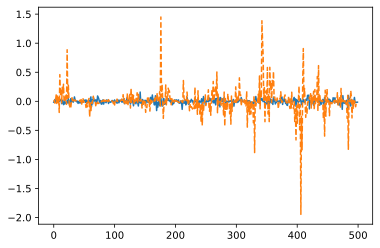

In [168]:
n_qubits = 8
n_layers = 3
n_reupload = 1

dev = qml.device('default.qubit', wires = n_qubits)

@jax.jit
@qml.qnode(dev, interface = 'jax')
def reupload_model(x, weights ):
    def S(x):
        for i in range(n_qubits):
            qml.RZ((3**(2*nr+i))*x, wires = i)
    # W takes (n_layer, n_qubits, 3) shape array        
    def W(weights, n_layers):
        for L in range(n_layers):
            
            for i in range(n_qubits):
                qml.Rot(weights[L,i,0], weights[L,i,1], weights[L,i,2], wires = i)
            for i in range(n_qubits-1):
                qml.CNOT(wires = [i,i+1])
            
    for nr in range(n_reupload):
        W(weights[nr,0], n_layers)
        S(x)
        W(weights[nr,1], n_layers)
    
    return qml.expval(qml.PauliZ(wires = [n_qubits-1]))

@jax.jit
@qml.qnode(dev, interface = 'jax')
def exp_model(x, weights ):
    def S(x):
        for i in range(n_qubits):
            qml.RZ((3**i)*x, wires = i)
          
    def W(weights, n_layers):
        for L in range(n_layers):
            for i in range(n_qubits):
                qml.Rot(weights[L,i,0], weights[L,i,1], weights[L,i,2], wires = i)
            for i in range(n_qubits-1):
                qml.CNOT(wires = [i,i+1])
            
    for i in range(n_qubits):
        qml.Hadamard(wires = i)
    S(x)
    W(weights, n_layers)
    
    return qml.expval(qml.PauliZ(wires = [n_qubits-1]))

key = jax.random.PRNGKey(np.random.randint(20000))
q_weights = params# 2 * jnp.pi *jax.random.normal(key, (n_layers,  n_qubits, 3) )

x = np.linspace(-np.pi,np.pi,500)
basis_s = tri_basis_tensor(n_qubits*n_reupload, x, 'exp')

q_target = [exp_model(xin, q_weights) for xin in x] 

max_bond = 2
coeff = coeff_tensor(n_qubits*n_reupload, max_bond)
coeff_auto =coeff.copy()
plt.plot(q_target ,label = 'q_target')
plt.plot(predict(coeff, basis_s), ls = '--', label = 'TN16')

In [169]:
opt = MPSOptimizer(coeff,x,q_target, tri_basis_tensor)
after_coeff=opt.update2(300,-0.05, max_bond = max_bond)
plt.plot(opt.loss_list)

  0%|          | 0/300 [00:14<?, ?it/s]


ValueError: Size of label 'd' for operand 1 (3) does not match previous terms (2).

In [170]:
## AD case
max_bond = 16
coeff = coeff_tensor(n_qubits*n_reupload, max_bond)
coeff_auto =coeff.copy()

def callback(tnopt):
    loss_list.append(tnopt.loss)
    return loss_list

loss_list = []
opt_auto = qtn.optimize.TNOptimizer(coeff_auto, loss, loss_constants = {'basis_s' : basis_s, 'target' : q_target}, optimizer = 'adam',autodiff_backend = 'jax',progbar = True, callback = callback)
after_coeff_auto = opt_auto.optimize(300, jac = True)

+0.000024042216 [best: +0.000024042216] : : 301it [17:26,  3.48s/it]                          


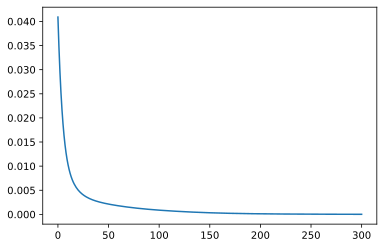

In [158]:
plt.plot(loss_list)

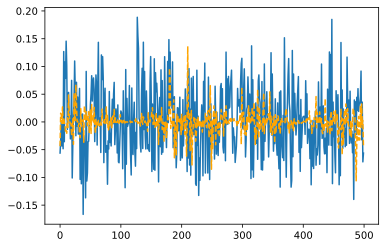

In [167]:
plt.plot(q_target)
# plt.plot(predict(coeff, basis_s), ls = '--')
plt.plot(predict(after_coeff_auto, basis_s), color = 'orange', ls = '--')

In [55]:
after_coeff_auto

<MatrixProductState(tensors=8, indices=15, L=8, max_bond=16)>

In [22]:
## do several times
def callback(tnopt):
    loss_list.append(tnopt.loss)
    return loss_list

coeff_list = [coeff.copy() for _ in range(3)]

losslist = []

for k in range(len(coeff_list)):
    opt = MPSOptimizer(coeff_list[k],x,q_target)
    opt.update2(300,-0.05, max_bond = 3*(k+1))
    losslist.append(opt.loss_list)
    
for k,loss in enumerate(losslist):
    plt.plot(loss, label =f'{3*(k+1)}')
plt.legend()

9th sweep


KeyboardInterrupt: 

In [7]:

def basis_tensor(length, xarray):
    def comps(x):
        return qtn.TensorNetwork([qtn.Tensor(np.array([np.exp(-1j*x), 1 , np.exp(1j*x)]), inds = [f'k{k}'], tags = [f'B{k}']) for k in range(length)])
    
    result = [comps(x) for x in xarray]
    return result


def tri_basis_tensor(length, xarray, enc_type):
    if enc_type == 'exp':
        def comps(x):
            return qtn.TensorNetwork([qtn.Tensor(np.array([np.cos((3**k)*x), 1 , np.sin((3**k)*x)]), inds = [f'b{k}'], tags = [f'B{k}']) for k in range(length)])
    elif enc_type == 'naive':   
        def comps(x):
            return qtn.TensorNetwork([qtn.Tensor(np.array([np.cos(x), 1 , np.sin(x)]), inds = [f'b{k}'], tags = [f'B{k}']) for k in range(length)])
    result = [comps(x) for x in xarray]
    return result
    
    
def coeff_tensor(length, bond_dim, dtype = 'float64'):
    # With basis_tensor as tensor products of 3 dimensional vectors, to make total function = basis_tensor @ coeff_tensor real, 
    # all matrix components of coeff tensor should satisfy 
    
    coeff = qtn.MPS_rand_state(L = length, bond_dim = bond_dim, phys_dim = 3, dtype = dtype).reindex({f'k{n}':f'b{n}' for n in range(length)})
    coeff.normalize()
    # coeff.canonize(int(np.floor((length-1)/2)))
    
    
    return coeff


def loss(coeff, basis_s, target):
    
    res = jnp.square(predict(coeff, basis_s) - jnp.array(target))
    return jnp.mean(res)

def predictone(coeff, basis):
    ##if real
    return coeff @ basis
    
    ## if imag
    # return ((coeff @ basis) + (coeff @ basis).conjugate()) /2

def predict(coeff, basis_s):
    
    res =jnp.array([ predictone(coeff, basis) for basis in basis_s])
    return res
    

